In [140]:
%matplotlib inline

from __future__ import print_function, division

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from torchvision.transforms import ToTensor

from torch.autograd import Variable
from torch.nn import Linear, Conv2d, Conv3d, ReLU, MaxPool2d, CrossEntropyLoss, Module, BatchNorm2d, Sequential, SELU, Dropout

from sklearn.cross_validation import train_test_split
from sklearn.cross_validation import StratifiedShuffleSplit

from skimage.transform import resize
import scipy.misc

import pandas as pd
import numpy as np
import os
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, transform
import random

import selectivesearch
import matplotlib.patches as mpatches
from matplotlib.patches import Rectangle
from pathlib import Path
from functools import reduce

# Step 1: Configuration

### some parameters for data preprocessing and training 

In [141]:
num_epochs = 15
batch_size = 16
learning_rate = 0.001
empty_test_data = 1000 # number of negative samples to collect
model_save_file = 'traffic_sign.pth'
csv_sep = ";"

# Step 2: Data Preprocessing and Dataset creation

### for example create negative samples and create Datasets

In [142]:
def createEmptyImages(image_path, gt_data, empty_folder="99"):
    """Create test images without traffic signs by taking all images without traffic signs 
    and then collect random positions
    
    Args:
        image_path -- path to the test images
        gt_data -- Dataframe with all of ground truth data
        empty_folder -- name of the folder which should contain the negative samples after creation (default=99)
    """
    
    # create folder if it doesn't exist
    if not os.path.exists(image_path+empty_folder):
        os.makedirs(image_path+empty_folder)
    
    # find images without any traffic sign
    images_without_sign = []
    image_exist = gt_data["img"].values

    for file in os.listdir(image_path):
        if file.endswith('.ppm'):
            num_findings = len(np.where(image_exist==file)[0])
            if num_findings == 0:
                images_without_sign.append(file)
    
    # create negative samples and save them
    i = 0
    empty_images = []
    current_image = io.imread(image_path+images_without_sign[0])
    while len(empty_images) < empty_test_data:
        if i % 50 == 0:
            current_image = io.imread(image_path+images_without_sign[random.randint(0, len(images_without_sign)-1)])
        x1 = random.randint(0, current_image.shape[1]-33)
        y1 = random.randint(0, current_image.shape[0]-33)
        crop = current_image[y1:y1+32,x1:x1+32]
        empty_images.append([crop, 100])
        scipy.misc.toimage(crop).save('./data/FullIJCNN2013/'+empty_folder+'/'+str(i)+'.ppm')
        i += 1
        
    return empty_images

### transformations for dataset creation

In [143]:
class ToSignTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        sign, sign_id, folder = sample['image'], sample['id'], sample['folder']

        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W
        image = sign.transpose((2, 0, 1))
        return {
                'image': torch.from_numpy(image),
                'id': sign_id,
                'folder': folder
               }
    
class ResizeSignImage(object):
    """Resize image in given size"""
    
    def __call__(self, sample):
        sign, sign_id, folder = sample['image'], sample['id'], sample['folder']
        
        #still numpy image: H x W x C
        sign = resize(sign, (32, 32, 3))
        
        return {'image': sign, 'id': sign_id, 'folder': folder}

In [144]:
class TrafficSignDataset(Dataset):
    def __init__(self, sign_data, root_dir, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.signs_frame = sign_data
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.signs_frame)

    def __getitem__(self, idx):
        # read image 
        image_folder = str(self.signs_frame.iloc[idx, 2])
        path = self.root_dir+image_folder+"/"
        img_name = os.path.join(path,
                                self.signs_frame.iloc[idx, 0])
        image = io.imread(img_name)
        
        sign_id = self.signs_frame.iloc[idx, 1]
        
        # save folder because sign_id is an integer and folder is a string. Zeros in numbers get cut off
        sample = {'image': image, 'id': sign_id, 'folder': image_folder}

        if self.transform:
            sample = self.transform(sample)

        return sample

In [145]:
def createSignCsv(folder):
    """Create and returns dataframe of all signs
    
    Args:
        folder -- path to data folder
    """
    images = []
    filenames = os.listdir(folder)
    
    for filename in filenames:
        path = os.path.join(os.path.abspath(folder), filename)
        if os.path.isdir(path):
            sign_images = os.listdir(path)
            for image_name in sign_images:
                img_id = filename.lstrip("0")
                if img_id == "":
                    img_id = 0
                images.append([image_name, img_id, filename])
        
    df = pd.DataFrame(images, columns=["image", "id", "path"])
    df.to_csv(folder+'sign_images.csv', index=False)
    
    return df

## read ground truth data, create negative samples and look at the data

In [146]:
use_saved_signs = False

/home/marvin/anaconda3/envs/or_project/lib/python3.6/site-packages/ipykernel/__main__.py:36: DeprecationWarning: `toimage` is deprecated!
`toimage` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use Pillow's ``Image.fromarray`` directly instead.


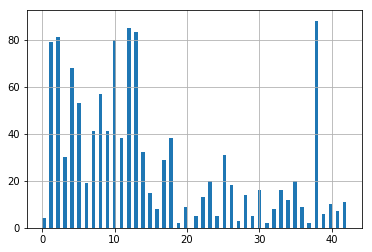

In [147]:
ground_truth_data = pd.read_csv('./data/FullIJCNN2013/gt.txt', sep=";", header=None)
ground_truth_data.columns = ["img", "x1", "y1", "x2", "y2", "id"]

empty_images = createEmptyImages('./data/FullIJCNN2013/', ground_truth_data) # images of no traffic signs [image, 100]

if not use_saved_signs:
    createSignCsv('./data/FullIJCNN2013/')
sign_data = pd.read_csv('./data/FullIJCNN2013/sign_images.csv', dtype={'path': 'str'}) # data with true traffic signs [filename, id]

non_empty = sign_data[sign_data.id != 99]["id"] # exclude 1000 images of id '99'
non_empty.hist(bins=86)

# Split whole data in train and test data

### also save both to csv file

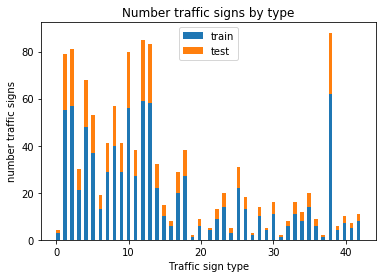

In [148]:
def stratifiedshufflesplit(data, test_size=0.3, thres=1):
    """create train and test data by propotion parameter
    
    Args:
        data -- the data to split
        test_size -- proportion of test data (default=0.3)
        thres -- minimum number of data (default=1)
    """
    y_less = data.groupby("id").filter(lambda x: len(x) <= thres)
    data = pd.concat([data, y_less], ignore_index=True)
    
    sss = StratifiedShuffleSplit(data['id'], 1, test_size=test_size)
    train_index, test_index =list(*sss)
    xtrain, xtest = data.iloc[train_index], data.iloc[test_index]

    return xtrain, xtest

def createSignData(data, path):
    """create train and test data and save it seperatly
    
    Args:
        data -- the full data
        path -- path to folder where csvn should be saved
    """
    xtrain, xtest = stratifiedshufflesplit(data, 0.3, 1)
    
    xtrain.to_csv(path+'/sign_train.csv', index=False)
    xtest.to_csv(path+'/sign_test.csv', index=False)
    
    return xtrain, xtest

xtrain, xtest = createSignData(sign_data, './data/FullIJCNN2013')

plt.hist([
            xtrain[xtrain.id != 99]["id"], # exclude 1000 non traffic signs images
            xtest[xtest.id != 99]["id"]
        ], 
        stacked=True, 
        label=["train", "test"],
        bins=86
    )

plt.title('Number traffic signs by type')
plt.xlabel('Traffic sign type')
plt.ylabel('number traffic signs')

plt.legend()

plt.show()

# Creation of Dataset

In [149]:
train_dataset = TrafficSignDataset(sign_data=xtrain,
                                    root_dir='./data/FullIJCNN2013/',
                                    transform=transforms.Compose([
                                                ResizeSignImage(),
                                                ToSignTensor()
                                           ]))

test_dataset = TrafficSignDataset(sign_data=xtest,
                                    root_dir='./data/FullIJCNN2013/',
                                    transform=transforms.Compose([
                                                ResizeSignImage(),
                                                ToSignTensor()
                                           ]))

train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True, drop_last=True)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=True, drop_last=True)

In [150]:
print(len(train_dataset))
print(len(test_dataset))

1549
664


# Look at some example data

/home/marvin/anaconda3/envs/or_project/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/marvin/anaconda3/envs/or_project/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


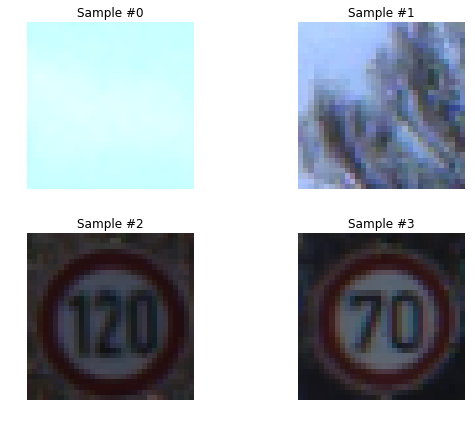

In [151]:
#plot some examples
fig = plt.figure(figsize=(8, 6))

def show_signs(image, folder):
    # swap color axis because
    # numpy image: H x W x C
    # torch image: C X H X W
    image = image.transpose((1, 2, 0))
    plt.imshow(image)
    
for i in range(4):
    sample = train_dataset[i]
    ax = plt.subplot(2, 2, i + 1)
    plt.tight_layout()
    ax.set_title('Sample #{}'.format(i))
    ax.axis('off')
    show_signs(sample['image'].numpy(), sample['folder'])

plt.show()

/home/marvin/anaconda3/envs/or_project/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/marvin/anaconda3/envs/or_project/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


0 torch.Size([16, 3, 32, 32])
1 torch.Size([16, 3, 32, 32])
2 torch.Size([16, 3, 32, 32])
3 torch.Size([16, 3, 32, 32])
4 torch.Size([16, 3, 32, 32])


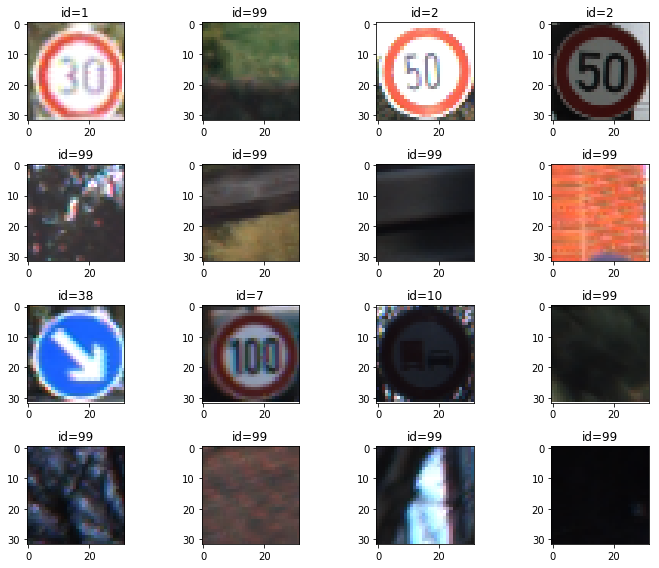

In [152]:
def show_signs_batch(sample_batched):
    """Show image in one batch"""
    images_batch = sample_batched['image'].numpy()
    ids_batch = sample_batched['id'].numpy()
    
    idx = 0
    for image in images_batch:
        ax = plt.subplot(4, 4, idx + 1)
        image = image.transpose((1, 2, 0))
        
        plt.imshow(image)
        plt.title('id='+str(ids_batch[idx]))
        
        idx += 1

for i_batch, sample_batched in enumerate(train_dataloader):
    print(i_batch, sample_batched['image'].size())

    # observe 4th batch and stop.
    if i_batch == 4:
        plt.figure(figsize=(10, 8))
        show_signs_batch(sample_batched)
        plt.tight_layout()
        plt.ioff()
        plt.show()
        break

# Step 3: creation of network and train/test

In [153]:
class TraffixSignDetection(Module):
    def __init__(self):
        super(TraffixSignDetection, self).__init__()
        
        self.conv1 = Conv2d(3, 16, 5, padding=2)
        self.conv2 = Conv2d(16, 32, 5, padding=2)
        
        self.pool = MaxPool2d(kernel_size=3, stride=2, padding=1)
        
        self.dropout = Dropout(p=0.92)
        
        self.activation2 = SELU()
        self.activation = ReLU()
        
        self.fc1 = Linear(2048, 512)
        self.fc2 = Linear(512, 128)
        self.fc3 = Linear(128, 2)
        
        self.bn1 = BatchNorm2d(16)
        self.bn2 = BatchNorm2d(32)
    
    def forward(self, x):
        # layer 1: convolution (outputs 6x14x14)
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.activation(out)
        out = self.pool(out)
        
        out = self.dropout(out)
        
        # layer 2: convolution (outputs 12x5x5)
        out = self.conv2(out)
        out = self.bn2(out)
        out = self.activation(out)
        out = self.pool(out)
    
        out = out.reshape(out.size(0), -1)
        
        out = self.fc1(out)
        out = self.activation(out)
        out = self.fc2(out)
        out = self.activation(out)
        out = self.fc3(out)
        
        return out

In [154]:
def idsToTensor(ids):
    """create tensor with expected values. ids 0-43 are traffic signs (value 1), id 99 is not (value 0)
    
    Args:
        ids -- list with traffic sign ids
    """
    expected = []
    for img_id in ids:
        if img_id == 99:
            expected.append(0)
        else:
            expected.append(1)
    arr = np.array(expected)
    ten = torch.from_numpy(arr)
    return ten    

def evaluate(model, dataloader):
    """test all test data and return accuracy
    
    Args:
        model -- network model
        dataloader -- data to test
    """
    acc = 0
    for i, data in enumerate(dataloader):
        images = Variable(data["image"])
        ids = idsToTensor(data["id"])
        signs = Variable(ids)
            
        prediction = model(images)
        
        acc += torch.mean(torch.eq(torch.argmax(prediction, dim=-1),
                                   signs).float())

    acc /= len(dataloader)

    acc = float(acc.detach().numpy())
    return acc

def train(model, train_dataloader, test_dataloader, use_gpu=False):
    """Train a given model

    Args:
        model: the model to train
        train_dataloader: data to use for training
        test_dataloader: data to use for testing
        use_gpu: if cuda is activated
    """

    if use_gpu:
        model.cuda()

    # needed to ploit the results later
    loss_values = []
    acc_values = []
        
    Loss = CrossEntropyLoss()
    #Optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9) # old optimizer
    Optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    for epoch in range(num_epochs):
        for i, data in enumerate(train_dataloader):
            train_step = i + len(train_dataloader)*epoch
            
            images = Variable(data["image"])
            ids = idsToTensor(data["id"])
            signs = Variable(ids)
            
            outputs = model(images)
            loss = Loss(outputs, signs)

            Optimizer.zero_grad()
            loss.backward()
            Optimizer.step()

        test_accuracy = evaluate(model, test_dataloader)
        loss_values.append(loss.item())
        acc_values.append(test_accuracy)
            
        print ('Epoch [{}/{}], Batch Accuracy: {}, Loss: {:.4f}' 
           .format(epoch+1, num_epochs, test_accuracy, loss.item()))
    
    return loss_values, acc_values

## noe train the network

In [155]:
model = TraffixSignDetection().double()
loss_values, acc_values = train(model, train_dataloader, test_dataloader)

/home/marvin/anaconda3/envs/or_project/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/marvin/anaconda3/envs/or_project/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


Epoch [1/15], Batch Accuracy: 0.8262194991111755, Loss: 0.4834
Epoch [2/15], Batch Accuracy: 0.8628048896789551, Loss: 0.4295
Epoch [3/15], Batch Accuracy: 0.8429877758026123, Loss: 0.2730
Epoch [4/15], Batch Accuracy: 0.8689024448394775, Loss: 0.4136
Epoch [5/15], Batch Accuracy: 0.8628048896789551, Loss: 0.1578
Epoch [6/15], Batch Accuracy: 0.8780487775802612, Loss: 0.2313
Epoch [7/15], Batch Accuracy: 0.9039633870124817, Loss: 0.2601
Epoch [8/15], Batch Accuracy: 0.8993902206420898, Loss: 0.2629
Epoch [9/15], Batch Accuracy: 0.9268292784690857, Loss: 0.1982
Epoch [10/15], Batch Accuracy: 0.9024389982223511, Loss: 0.3918
Epoch [11/15], Batch Accuracy: 0.9070122241973877, Loss: 0.0563
Epoch [12/15], Batch Accuracy: 0.9237805008888245, Loss: 0.2504
Epoch [13/15], Batch Accuracy: 0.917682945728302, Loss: 0.1583
Epoch [14/15], Batch Accuracy: 0.9222561120986938, Loss: 0.1170
Epoch [15/15], Batch Accuracy: 0.9070122241973877, Loss: 0.0599


In [156]:
# save the network for later use
torch.save(model.state_dict(), model_save_file)

### plot the luss and accuracy

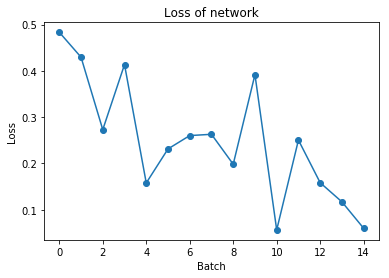

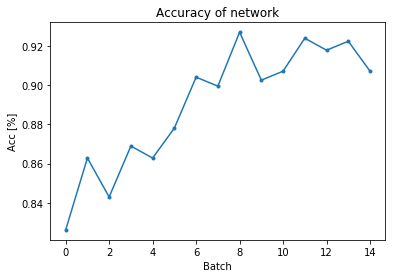

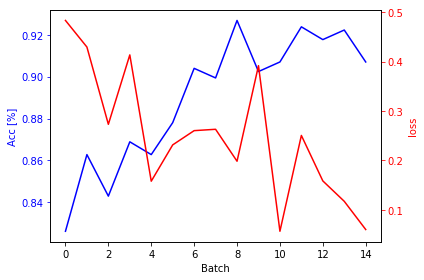

In [157]:

plt.plot(loss_values, 'o-')
plt.title('Loss of network')
plt.xlabel('Batch')
plt.ylabel('Loss')
plt.show()

plt.plot(acc_values, '.-')
plt.title('Accuracy of network')
plt.xlabel('Batch')
plt.ylabel('Acc [%]')
plt.show()

fig, ax1 = plt.subplots()
ax1.plot(acc_values, 'b-')
plt.xlabel('Batch')
# Make the y-axis label, ticks and tick labels match the line color.
ax1.set_ylabel('Acc [%]', color='b')
ax1.tick_params('y', colors='b')

ax2 = ax1.twinx()
ax2.plot(loss_values, 'r-')
ax2.set_ylabel('loss', color='r')
ax2.tick_params('y', colors='r')

fig.tight_layout()
plt.show()


In [158]:
def trySomeImage(model, img):
    img = resize(img, (32, 32, 3))
    img = img.transpose((2, 0, 1))
    
    inp = torch.from_numpy(img)
    inp = inp.view(1, 3, 32, 32)
    out = model(inp)
    return out

def trySomeImagePath(model, img_path='./data/FullIJCNN2013/40/00004.ppm'):
    """return the output of a model for given image path
    
    Args:
        model -- model of the network
        img_path -- the image to try (default='./data/FullIJCNN2013/40/00004.ppm')
    """
    img = io.imread(img_path)
    out = trySomeImage(model, img)
    
    return out

In [159]:
use_saved_model = True

if use_saved_model:
    model = TraffixSignDetection().double()
    model.load_state_dict(torch.load(model_save_file))

# test some image
t = trySomeImagePath(model, './data/FullIJCNN2013/01/00000.ppm')
print(t)

tensor([[-6.9134,  6.7431]], dtype=torch.float64)


/home/marvin/anaconda3/envs/or_project/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/marvin/anaconda3/envs/or_project/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


# Step 4: get interesting regions and test them

In [161]:
use_saved_regions = True
region_file = 'regions'
region_columns = ["img", "x1", "y1", "x2", "y2"]
debug = False

data_path = "./data/FullIJCNN2013/"
# selective search params
scale = 250
sigma = 0.9
region_file_path = data_path+region_file+"_"+str(scale)+"_"+str(sigma).replace(".", "")+".csv"

In [162]:
def get_regions_csv_data(img_name, regions):
    """filter regions and save the filtered ones
    
    Args:
        img_name -- name of the current image
        regions -- all interesting regions of the image
    """
    candidates = []
    csv_data = []
    for r in regions:
        # excluding same rectangle (with different segments)
        if r['rect'] in candidates:
            continue
        # excluding regions smaller than 100 and bigger than 6500 pixels
        if r['size'] < 100 or r['size'] > 6500:
            continue

        x, y, w, h = r['rect']
        # distorted rects
        if w < 15 or h < 15:
            continue
        if w / h > 1.15 or h / w > 1.15:
            continue        
        
        candidates.append(r['rect'])
        csv_data.append([img_name, x, y, x+w, y+h])
        
    return csv_data

In [163]:
if not use_saved_regions or not Path(region_file_path).is_file(): # if there are no saved regions find them
    csv = []
    # create csv of regions  
    num_imgs = 40 # number of images to find regions
    for img_idx in range(num_imgs):
        img_name = '{0:05d}'.format(img_idx) + ".ppm"
        img = io.imread(data_path+img_name)
        img_lbl, regions = selectivesearch.selective_search(img, scale=scale, sigma=sigma, min_size=10)
        
        if debug:
            plt.imshow(img)
            plt.show()
            regions[:10]
            
        csv.append(get_regions_csv_data(img_name, regions))
        
    complete_csv = [item for sublist in csv for item in sublist]

    # save all regions in a csv file
    df = pd.DataFrame(np.array(complete_csv), columns=region_columns)
    df.to_csv(region_file_path, index=False, sep=csv_sep)

In [164]:
all_regions = pd.read_csv(region_file_path, sep=csv_sep, header=0)
all_regions.columns = region_columns

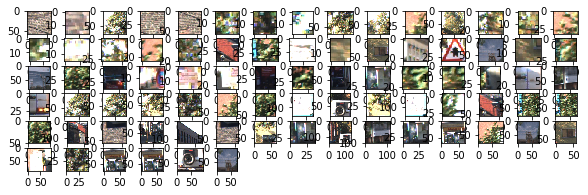

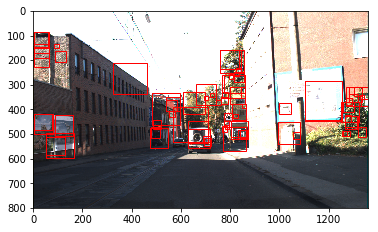

In [165]:
def plot_sample_regions(regions, path, cols=15, rows=20):
    """simple plot function to plot some regions 
    
    Args:
        regions -- regions to plot
        path -- path to images
        cols -- columns in the subplot (default=15)
        cols -- rows in the subplot (default=20)
    """
    regions = regions[:cols*rows]
    i = 1
    fig = plt.figure(figsize=(10,10))
    
    for index, region in regions.iterrows():
        img_name = region["img"]
        x1, y1, x2, y2 = region[["x1", "y1", "x2", "y2"]]
        
        img = io.imread(path+img_name)
        
        a = fig.add_subplot(20, 15, i)
        imgplot = plt.imshow(img[y1:y2, x1:x2])
        i += 1

    plt.show()
    
def plot_regions_of_image(regions, path, img_name):
    """simple plot function to plot some regions  in image
    
    Args:
        regions -- regions to plot
        path -- path to images
        img_name -- the image for the regions
    """
    fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(6, 6))
    
    img = io.imread(path+img_name)
    ax.imshow(img)
    
    for index, region in regions.iterrows():
        x1, y1, x2, y2 = region[["x1", "y1", "x2", "y2"]]
        
        rect = mpatches.Rectangle(
            (x1, y1), x2-x1, y2-y1, fill=False, edgecolor='red', linewidth=1)
        ax.add_patch(rect)

    plt.show()
    
plot_sample_regions(all_regions[(all_regions.img == '00000.ppm')], data_path)
plot_regions_of_image(all_regions[(all_regions.img == '00000.ppm')], data_path, '00000.ppm')

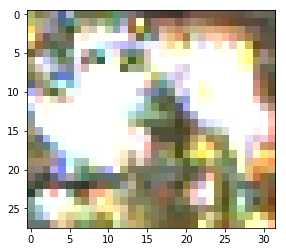

tensor([[ 3.6792, -5.0789]], dtype=torch.float64)


/home/marvin/anaconda3/envs/or_project/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/marvin/anaconda3/envs/or_project/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


In [166]:
def show_region_with_index(regions, index):
    """test function to plot one single region
    
    Args:
        regions -- all regions
        index -- the index for the region to plot
    """
    r = regions.iloc[[index]]
    r = r.values[0]

    img_name, x1, y1, x2, y2 = r

    img = io.imread(data_path+img_name)

    plt.imshow(img[y1:y2, x1:x2])
    plt.show()
    
    return img[y1:y2, x1:x2]

test_img = show_region_with_index(all_regions, 17)
print(trySomeImage(model, test_img))

# Step 5: test our detector and look how accurate it is

In [167]:
def get_signs_from_regions(all_regions, last_image="00040.ppm"):
    """classify all images in all_regions parameter and returns the one which are traffic signs 
        with higher probability
    
    Args:
        all_regions -- all regions to classify
        last_image -- the last image which will not be classified
    """
    with_sign = []
    for index, region in all_regions.iterrows():
        img_name = region['img']

        if img_name == last_image:
            break

        img = io.imread(data_path+img_name)
        x1, y1, x2, y2 = region[["x1", "y1", "x2", "y2"]]
        test_img = img[y1:y2, x1:x2]
        
        out = trySomeImage(model, test_img) # get output of network

        target = torch.argmax(out, dim=-1).numpy()[0]
        
        if target == 1:
            obj = {"image": test_img, "output":out, "cords": [x1, y1, x2, y2], "img_name": img_name}
            with_sign.append(obj)
            
    return with_sign
            
def plot_some_images(img_container, no_imgs=20, rows=10, cols=10):
    """test function to plot some images
    
    Args:
        img_container -- list of all images 
        no_imgs -- limit number of images to plot (default=20)
        rows -- rows in the subplot (default=10)
        cols -- columns in the subplot (default=10)
    """
    i = 1
    fig = plt.figure(figsize=(10,10))
    for s in img_container[:no_imgs]:
        a = fig.add_subplot(rows, cols, i)
        imgplot = plt.imshow(s["image"])
        i += 1

    plt.show()

In [169]:
print("start of classification of all regions...")

start of classification of all regions...


/home/marvin/anaconda3/envs/or_project/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/marvin/anaconda3/envs/or_project/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


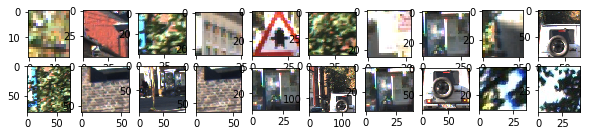

In [168]:
sign_images = get_signs_from_regions(all_regions)
plot_some_images(sign_images)

In [170]:
def jaccard(boxA, boxB):
    ''' Function that calculates the intersection over union between two given bouding boxes
    
    Args: 
        boxA -- description of first bounding box (x1, y1, x2, y2)
        boxB -- description of second bounding box (x1, y1, x2, y2)
    '''
    
    
    # determine the (x, y)-coordinates of the intersection rectangle
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])
    
    # compute the area of intersection rectangle
    interArea = (xB - xA) * (yB - yA)
    # catch the case of no intersection at all (interArea < 0)
    if (xB - xA) <= 0 or (yB - yA) <= 0:
        interArea = 0
    
    # compute the area of both the prediction and ground-truth rectangles
    boxAArea = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    boxBArea = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])

    # compute the intersection over union by taking the intersection
    # area and dividing it by the sum of (prediction + ground-truth
    # areas - the interesection area)
    iou = interArea / float(boxAArea + boxBArea - interArea)
    
    return iou

In [171]:
def calculate_accuracy(ground_truth, computed, nr_img=1, suc_tresh=0.5):
    """Calculate the accuracy of our traffic sign detector
    
    Args:
        ground_truth -- ground truth data
        computed -- regions in images that should display a traffic sign
        nr_img -- the number of images to test (default=1)
        suc_tresh -- the min jaccard distance to have a sucessful detection (default=0.5)
    """
    mean_all_images = []
    num_false_positives = []
    for img_index in range(nr_img): # iterate over all number of wanted images
        img_name = '{0:05d}'.format(img_index) + ".ppm"
        img_data = ground_truth[(ground_truth.img == img_name)]
        
        if(img_data.empty): # if there are no traffic signs in this image continue with the next one
            continue
        
        num_signs_in_image = len(img_data)
        sign_founds = 0
        
        computed_img_data = computed[(computed.img_name == img_name)]
        num_found_signs = len(computed_img_data)
            
        for index, sign in img_data.iterrows(): # iterate over all true signs in one image
            
            gt = sign[["x1", "y1", "x2", "y2"]].values # ground truth coordinates
            
            for index, found_sign in computed_img_data.iterrows(): # iterate over all computed traffic sign regions
                found_cords = found_sign["cords"]
                jac = jaccard(gt, found_cords)
                if jac > suc_tresh:
                    sign_founds += 1
                    break

        mean_all_images.append(sign_founds / num_signs_in_image)
        num_false_positives.append(num_found_signs - num_signs_in_image)
            
    return mean_all_images, num_false_positives
    
computed_dataframe = pd.DataFrame.from_dict(sign_images)
mean_all_images, num_false_positives = calculate_accuracy(ground_truth_data, computed_dataframe, nr_img=40)

print(mean_all_images)
print(num_false_positives)

[1.0, 0.3333333333333333, 0.0, 0.3333333333333333, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.5, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.5, 0.0, 0.0, 0.0, 0.5, 0.0, 0.0, 0.0, 1.0]
[17, 31, 17, 23, 21, 9, 3, 23, 16, 2, 19, 17, 27, 21, 29, 23, 31, -1, 19, 7, 23, 3, 10, 23, 4, 15, 8, 37, 14, 15, 41, 39, 33, 30, 8, 39, 25, 28, 57, 58]


## finally our accuracy of the traffic sign detector

In [172]:
reduce(lambda x, y: x + y, mean_all_images) / len(mean_all_images)

0.32916666666666666